In [83]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [84]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [85]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [86]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [87]:
prep = preprocess(data, ada = True)

In [88]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [89]:
model = xgb.XGBClassifier(learning_rate = 0.015, 
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          colsample_bytree=0.5,
                          max_depth=6,
                          n_estimators = 5000)

In [90]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.680064
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.67487
[2]	validation_0-logloss:0.662245
[3]	validation_0-logloss:0.655522
[4]	validation_0-logloss:0.643549
[5]	validation_0-logloss:0.632051
[6]	validation_0-logloss:0.620812
[7]	validation_0-logloss:0.614984
[8]	validation_0-logloss:0.609075
[9]	validation_0-logloss:0.603477
[10]	validation_0-logloss:0.597604
[11]	validation_0-logloss:0.587231
[12]	validation_0-logloss:0.581928
[13]	validation_0-logloss:0.576926
[14]	validation_0-logloss:0.571473
[15]	validation_0-logloss:0.56179
[16]	validation_0-logloss:0.557242
[17]	validation_0-logloss:0.547856
[18]	validation_0-logloss:0.543246
[19]	validation_0-logloss:0.534167
[20]	validation_0-logloss:0.525358
[21]	validation_0-logloss:0.5209
[22]	validation_0-logloss:0.512499
[23]	validation_0-logloss:0.504232
[24]	validation_0-logloss:0.500104
[25]	validation_0-logloss:0.496236
[26]	validation_0-logloss:0.492434


[230]	validation_0-logloss:0.122128
[231]	validation_0-logloss:0.121896
[232]	validation_0-logloss:0.121699
[233]	validation_0-logloss:0.1216
[234]	validation_0-logloss:0.121004
[235]	validation_0-logloss:0.120827
[236]	validation_0-logloss:0.120172
[237]	validation_0-logloss:0.119914
[238]	validation_0-logloss:0.11929
[239]	validation_0-logloss:0.118744
[240]	validation_0-logloss:0.118575
[241]	validation_0-logloss:0.118018
[242]	validation_0-logloss:0.117469
[243]	validation_0-logloss:0.117285
[244]	validation_0-logloss:0.11711
[245]	validation_0-logloss:0.116544
[246]	validation_0-logloss:0.115976
[247]	validation_0-logloss:0.115461
[248]	validation_0-logloss:0.114923
[249]	validation_0-logloss:0.114411
[250]	validation_0-logloss:0.114296
[251]	validation_0-logloss:0.113773
[252]	validation_0-logloss:0.113712
[253]	validation_0-logloss:0.113561
[254]	validation_0-logloss:0.113485
[255]	validation_0-logloss:0.113426
[256]	validation_0-logloss:0.112917
[257]	validation_0-logloss:0.112

[459]	validation_0-logloss:0.080495
[460]	validation_0-logloss:0.080404
[461]	validation_0-logloss:0.080284
[462]	validation_0-logloss:0.080197
[463]	validation_0-logloss:0.080141
[464]	validation_0-logloss:0.080042
[465]	validation_0-logloss:0.079951
[466]	validation_0-logloss:0.079907
[467]	validation_0-logloss:0.079809
[468]	validation_0-logloss:0.079774
[469]	validation_0-logloss:0.079708
[470]	validation_0-logloss:0.079611
[471]	validation_0-logloss:0.079519
[472]	validation_0-logloss:0.079441
[473]	validation_0-logloss:0.079432
[474]	validation_0-logloss:0.079382
[475]	validation_0-logloss:0.079312
[476]	validation_0-logloss:0.079246
[477]	validation_0-logloss:0.079131
[478]	validation_0-logloss:0.079084
[479]	validation_0-logloss:0.079003
[480]	validation_0-logloss:0.078962
[481]	validation_0-logloss:0.07892
[482]	validation_0-logloss:0.078866
[483]	validation_0-logloss:0.078858
[484]	validation_0-logloss:0.078825
[485]	validation_0-logloss:0.078758
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.070484
[689]	validation_0-logloss:0.070456
[690]	validation_0-logloss:0.070433
[691]	validation_0-logloss:0.070411
[692]	validation_0-logloss:0.070384
[693]	validation_0-logloss:0.070366
[694]	validation_0-logloss:0.070322
[695]	validation_0-logloss:0.070295
[696]	validation_0-logloss:0.070245
[697]	validation_0-logloss:0.070238
[698]	validation_0-logloss:0.07019
[699]	validation_0-logloss:0.070183
[700]	validation_0-logloss:0.070181
[701]	validation_0-logloss:0.070164
[702]	validation_0-logloss:0.070141
[703]	validation_0-logloss:0.070139
[704]	validation_0-logloss:0.070122
[705]	validation_0-logloss:0.070105
[706]	validation_0-logloss:0.070077
[707]	validation_0-logloss:0.07004
[708]	validation_0-logloss:0.070014
[709]	validation_0-logloss:0.069998
[710]	validation_0-logloss:0.069975
[711]	validation_0-logloss:0.069964
[712]	validation_0-logloss:0.069957
[713]	validation_0-logloss:0.069921
[714]	validation_0-logloss:0.069918
[715]	validation_0-logloss:0.0

[917]	validation_0-logloss:0.066531
[918]	validation_0-logloss:0.066519
[919]	validation_0-logloss:0.066522
[920]	validation_0-logloss:0.066518
[921]	validation_0-logloss:0.066501
[922]	validation_0-logloss:0.066458
[923]	validation_0-logloss:0.066428
[924]	validation_0-logloss:0.06643
[925]	validation_0-logloss:0.066446
[926]	validation_0-logloss:0.066446
[927]	validation_0-logloss:0.066462
[928]	validation_0-logloss:0.066451
[929]	validation_0-logloss:0.06643
[930]	validation_0-logloss:0.066408
[931]	validation_0-logloss:0.066405
[932]	validation_0-logloss:0.066415
[933]	validation_0-logloss:0.06642
[934]	validation_0-logloss:0.066391
[935]	validation_0-logloss:0.066364
[936]	validation_0-logloss:0.066357
[937]	validation_0-logloss:0.066323
[938]	validation_0-logloss:0.066314
[939]	validation_0-logloss:0.066309
[940]	validation_0-logloss:0.066267
[941]	validation_0-logloss:0.066274
[942]	validation_0-logloss:0.066274
[943]	validation_0-logloss:0.066266
[944]	validation_0-logloss:0.06

[1142]	validation_0-logloss:0.064758
[1143]	validation_0-logloss:0.064769
[1144]	validation_0-logloss:0.064769
[1145]	validation_0-logloss:0.064776
[1146]	validation_0-logloss:0.064759
[1147]	validation_0-logloss:0.064761
[1148]	validation_0-logloss:0.064759
[1149]	validation_0-logloss:0.064763
[1150]	validation_0-logloss:0.064763
[1151]	validation_0-logloss:0.064757
[1152]	validation_0-logloss:0.064757
[1153]	validation_0-logloss:0.064751
[1154]	validation_0-logloss:0.064736
[1155]	validation_0-logloss:0.064715
[1156]	validation_0-logloss:0.06472
[1157]	validation_0-logloss:0.064718
[1158]	validation_0-logloss:0.064715
[1159]	validation_0-logloss:0.064717
[1160]	validation_0-logloss:0.064715
[1161]	validation_0-logloss:0.064719
[1162]	validation_0-logloss:0.064696
[1163]	validation_0-logloss:0.064699
[1164]	validation_0-logloss:0.064678
[1165]	validation_0-logloss:0.064674
[1166]	validation_0-logloss:0.064675
[1167]	validation_0-logloss:0.064684
[1168]	validation_0-logloss:0.064678
[1

[1365]	validation_0-logloss:0.06332
[1366]	validation_0-logloss:0.063326
[1367]	validation_0-logloss:0.063315
[1368]	validation_0-logloss:0.063307
[1369]	validation_0-logloss:0.063308
[1370]	validation_0-logloss:0.063308
[1371]	validation_0-logloss:0.063319
[1372]	validation_0-logloss:0.063323
[1373]	validation_0-logloss:0.063311
[1374]	validation_0-logloss:0.063305
[1375]	validation_0-logloss:0.063301
[1376]	validation_0-logloss:0.063306
[1377]	validation_0-logloss:0.063304
[1378]	validation_0-logloss:0.063296
[1379]	validation_0-logloss:0.063311
[1380]	validation_0-logloss:0.063319
[1381]	validation_0-logloss:0.063314
[1382]	validation_0-logloss:0.0633
[1383]	validation_0-logloss:0.063299
[1384]	validation_0-logloss:0.063287
[1385]	validation_0-logloss:0.063285
[1386]	validation_0-logloss:0.063288
[1387]	validation_0-logloss:0.063282
[1388]	validation_0-logloss:0.063283
[1389]	validation_0-logloss:0.063272
[1390]	validation_0-logloss:0.063276
[1391]	validation_0-logloss:0.063258
[139

[1588]	validation_0-logloss:0.062796
[1589]	validation_0-logloss:0.062791
[1590]	validation_0-logloss:0.062786
[1591]	validation_0-logloss:0.062786
[1592]	validation_0-logloss:0.062782
[1593]	validation_0-logloss:0.062783
[1594]	validation_0-logloss:0.062777
[1595]	validation_0-logloss:0.062766
[1596]	validation_0-logloss:0.06276
[1597]	validation_0-logloss:0.062761
[1598]	validation_0-logloss:0.062778
[1599]	validation_0-logloss:0.062783
[1600]	validation_0-logloss:0.062783
[1601]	validation_0-logloss:0.062773
[1602]	validation_0-logloss:0.06278
[1603]	validation_0-logloss:0.062783
[1604]	validation_0-logloss:0.06279
[1605]	validation_0-logloss:0.062786
[1606]	validation_0-logloss:0.062796
[1607]	validation_0-logloss:0.062789
[1608]	validation_0-logloss:0.062805
[1609]	validation_0-logloss:0.062803
[1610]	validation_0-logloss:0.062793
[1611]	validation_0-logloss:0.062771
[1612]	validation_0-logloss:0.062762
[1613]	validation_0-logloss:0.062768
[1614]	validation_0-logloss:0.062773
[161

[1811]	validation_0-logloss:0.062866
[1812]	validation_0-logloss:0.062873
[1813]	validation_0-logloss:0.062876
[1814]	validation_0-logloss:0.062886
[1815]	validation_0-logloss:0.062896
[1816]	validation_0-logloss:0.062893
[1817]	validation_0-logloss:0.062899
[1818]	validation_0-logloss:0.062902
[1819]	validation_0-logloss:0.062904
[1820]	validation_0-logloss:0.062894
[1821]	validation_0-logloss:0.062882
Stopping. Best iteration:
[1621]	validation_0-logloss:0.062744



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [91]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [92]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [95]:
res = y_pred[:,1]

In [96]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [97]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [98]:
log_loss(answer["Stage"], answer["Prediction"])

0.07169431417683689

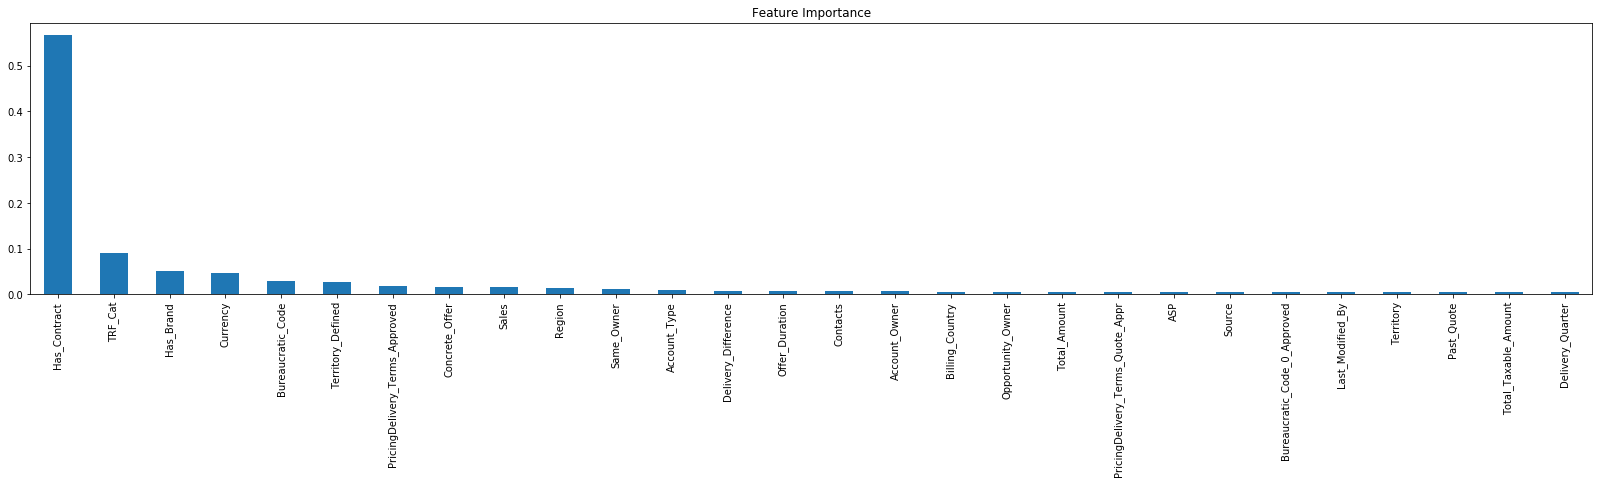

In [73]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [74]:
print feat_imp

Has_Contract                        0.566336
TRF_Cat                             0.090017
Has_Brand                           0.051169
Currency                            0.047416
Bureaucratic_Code                   0.028134
Territory_Defined                   0.026371
PricingDelivery_Terms_Approved      0.019211
Concrete_Offer                      0.016137
Sales                               0.015528
Region                              0.014856
Same_Owner                          0.011127
Account_Type                        0.008677
Delivery_Difference                 0.008176
Offer_Duration                      0.007925
Contacts                            0.007900
Account_Owner                       0.006176
Billing_Country                     0.006058
Opportunity_Owner                   0.005908
Total_Amount                        0.005781
PricingDelivery_Terms_Quote_Appr    0.005754
ASP                                 0.005655
Source                              0.005476
Bureaucrat

In [75]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali, ada = True)

In [76]:
validation.head()

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote
0,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.325,0.36761,1.0,162240.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
1,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.320,0.36195,1.0,78624.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
2,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.275,0.31105,1.0,126555.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
3,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10690.0,788.0,0.0,0.0,0.0,1.0,1.0,0.325,0.36761,1.0,243360.0,757783.5,5.0,27.0,1.0,0.0,1.0,0.0,1.0,30.0,77.0,18.0,1.0,-5.0
4,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10690.0,788.0,0.0,0.0,0.0,1.0,1.0,0.320,0.36195,1.0,157248.0,757783.5,5.0,28.0,1.0,0.0,1.0,0.0,0.0,30.0,78.0,18.0,1.0,-5.0


In [77]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [78]:
pred_vali = pred[:,1]

In [79]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [80]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [81]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9946415825505095

In [82]:
answer.to_csv("best/model_xgboost_pred.csv", index = False, header = False)

In [94]:
model.fit(prep.drop(target, axis=1), 
          prep.Stage, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
y_pred_full = model.predict_proba(prep.drop(target, axis=1))
y_pred_full = y_pred_full[:,1]

In [102]:
pred = pd.DataFrame(y_pred_full, index = prep.index, columns = ["Prediction"])

In [104]:
pred_full = prep.join(pred)
answer_full = pred_full.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [106]:
log_loss(answer_full["Stage"], answer_full["Prediction"])

0.05342313995799043

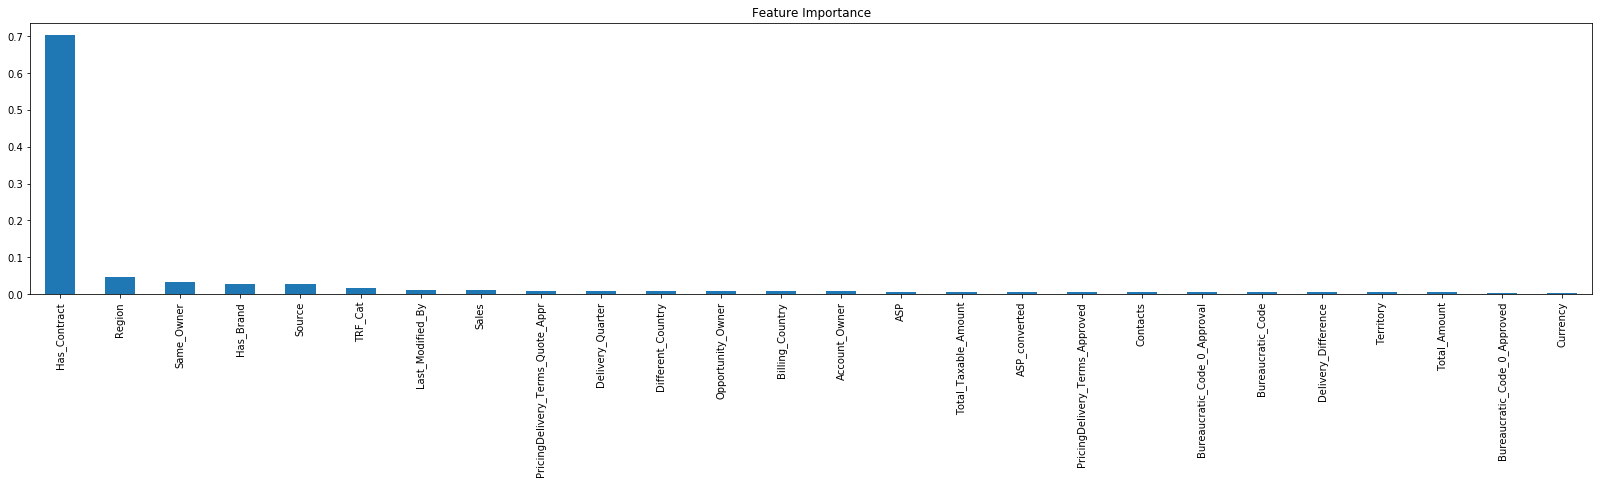

In [108]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')